Custom Gym Environment

In [1]:
import gymnasium as gym
import numpy as np
import pyautogui
from mss import mss
from PIL import Image
import time
import win32gui
import win32con
import cv2
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import hashlib

class GeometryDashEnv(gym.Env):
    def __init__(self):
        super(GeometryDashEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(360, 640, 1), dtype=np.uint8)
        self.sct = mss()
        self.window_name = "Geometry Dash"
        self.window_rect = self._get_window_rect()
        self.seen_columns = set()
        self.menu_template = self._load_template('templates/menu_template.png')
        pyautogui.press('space')

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        time.sleep(0.2)
        self.seen_columns.clear()
        pyautogui.press('space')
        return self._get_observation(), {}

    def step(self, action):
        self._execute_action(action)
        time.sleep(0.1)

        obs = self._get_observation()
    
        if self._is_game_over(obs):
            reward = -15
            obs, _ = self.reset()
            terminated = True
            truncated = False
        else:
            reward = self._calculate_reward(obs, action)
            terminated = False
            truncated = False
            
        return obs, reward, terminated, truncated, {}

    def _get_window_rect(self):
        hwnd = win32gui.FindWindow(None, self.window_name)
        if hwnd == 0:
            raise RuntimeError("Window not found. Ensure the game is running and titled 'Geometry Dash'.")
        
        win32gui.ShowWindow(hwnd, win32con.SW_RESTORE)
        time.sleep(0.1)
        
        try:
            win32gui.SetForegroundWindow(hwnd) # If SetForegroundWindow() is not working, try using SetActiveWindow().
        except Exception as e:
            print(f"Error bringing window to the foreground: {e}")
            raise
        
        time.sleep(0.5)
        rect = win32gui.GetWindowRect(hwnd)
        return {"top": rect[1], "left": rect[0], "width": rect[2] - rect[0], "height": rect[3] - rect[1]}

    def _load_template(self, path):
        template = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if template is None:
            raise FileNotFoundError(f"Template image not found at {path}.")
        return cv2.resize(template, (640, 360))

    def _is_game_over(self, obs):
        obs = obs.squeeze().astype(np.uint8)
        result = cv2.matchTemplate(obs, self.menu_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        return max_val >= 0.7 # Game is over if match is >= to 70%

    def _calculate_reward(self, obs, action):
        reward = 0
        right_columns = obs[:, -5:]
        column_hash = self._hash_observation(right_columns)
        
        if column_hash not in self.seen_columns:
            self.seen_columns.add(column_hash)
            reward += 1

        if action == 1:
            reward -= 0.05
        elif action == 2:
            reward -= 0.5
        
        return reward
 
    def _get_observation(self):
        screenshot = self.sct.grab(self.window_rect)
        img = Image.frombytes("RGB", (screenshot.width, screenshot.height), screenshot.rgb)
        img = img.convert("L").resize((640, 360))
        img = np.array(img)[..., np.newaxis]
        return img

    def _hash_observation(self, observation):
        return hashlib.sha256(observation.tobytes()).hexdigest()

    def _execute_action(self, action):
        if action == 1:
            pyautogui.press('w')
        elif action == 2:
            pyautogui.keyDown('w')
        else:
            pyautogui.keyUp('w')

    # Here to avoid errors, not necessary
    def render(self, mode='human'):
        pass

    def close(self):
        self.sct.close()

Custom Environment Testing


--- Episode 1 ---


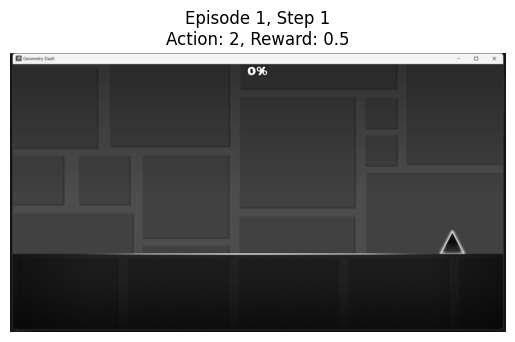

Step 1: Action=2, Reward=0.5, Terminated=False


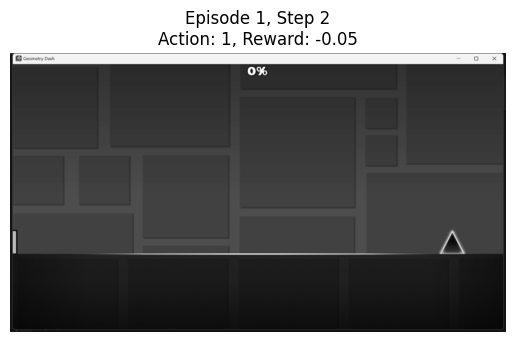

Step 2: Action=1, Reward=-0.05, Terminated=False


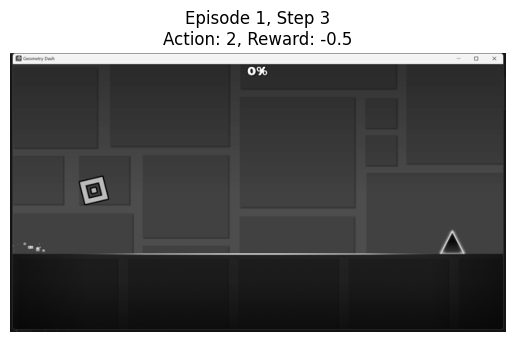

Step 3: Action=2, Reward=-0.5, Terminated=False


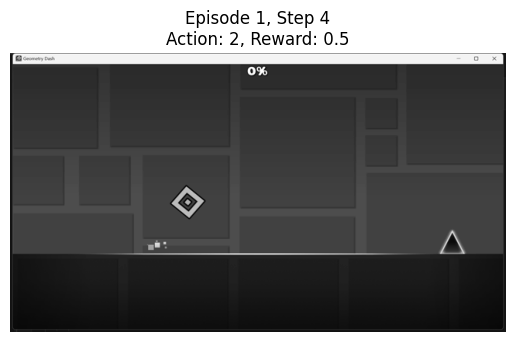

Step 4: Action=2, Reward=0.5, Terminated=False


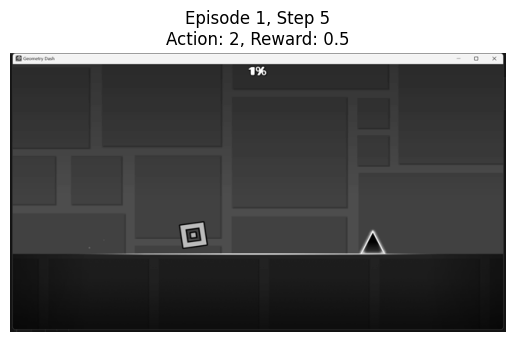

Step 5: Action=2, Reward=0.5, Terminated=False


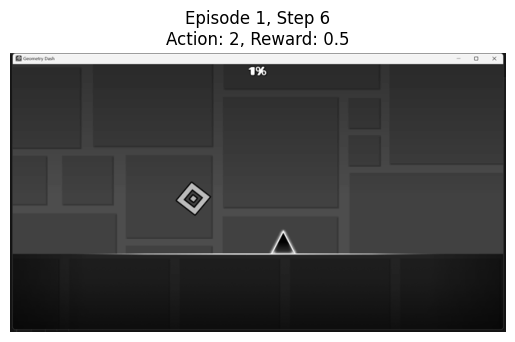

Step 6: Action=2, Reward=0.5, Terminated=False


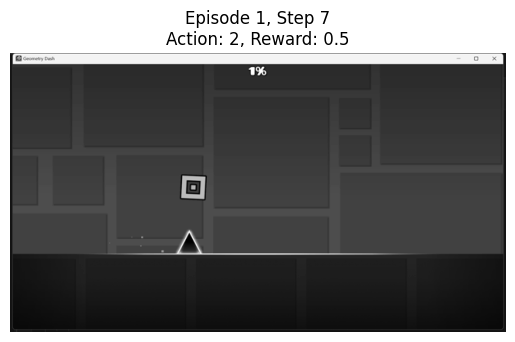

Step 7: Action=2, Reward=0.5, Terminated=False


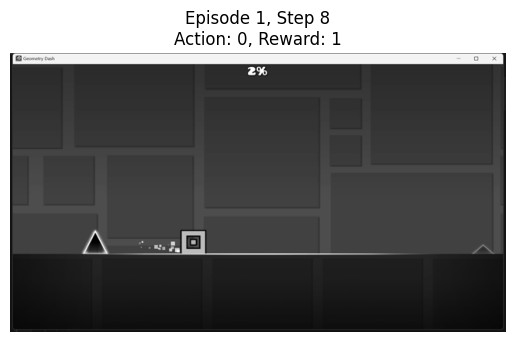

Step 8: Action=0, Reward=1, Terminated=False


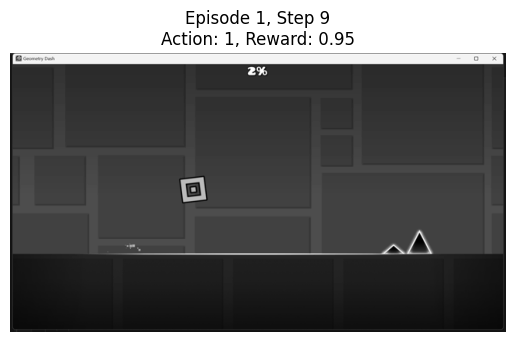

Step 9: Action=1, Reward=0.95, Terminated=False


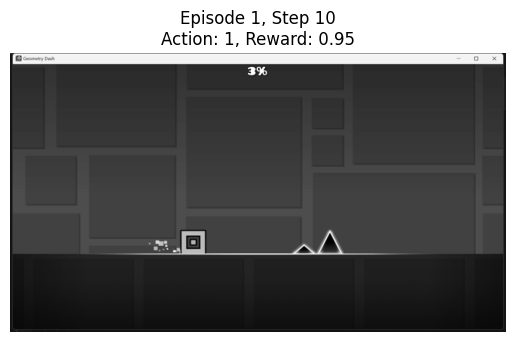

Step 10: Action=1, Reward=0.95, Terminated=False


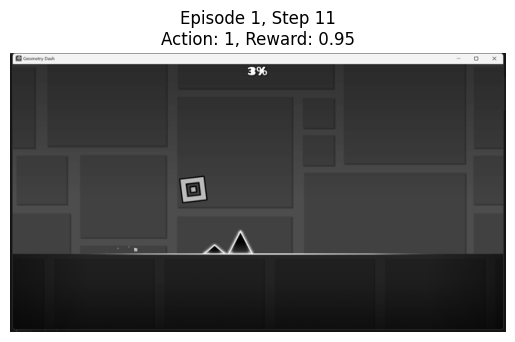

Step 11: Action=1, Reward=0.95, Terminated=False


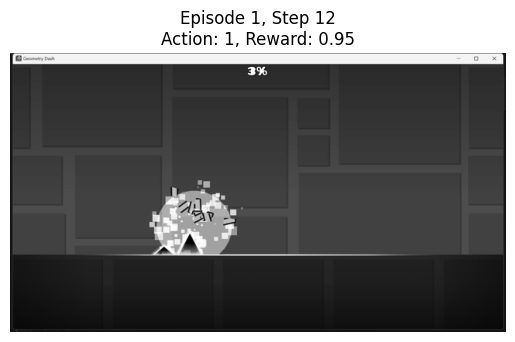

Step 12: Action=1, Reward=0.95, Terminated=False


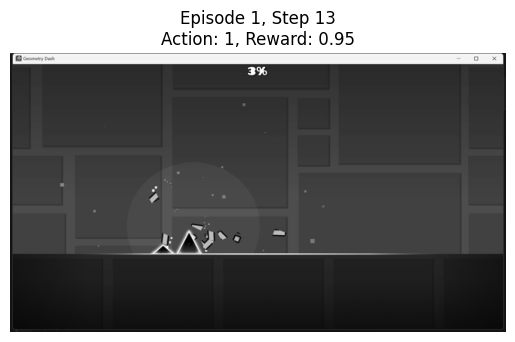

Step 13: Action=1, Reward=0.95, Terminated=False


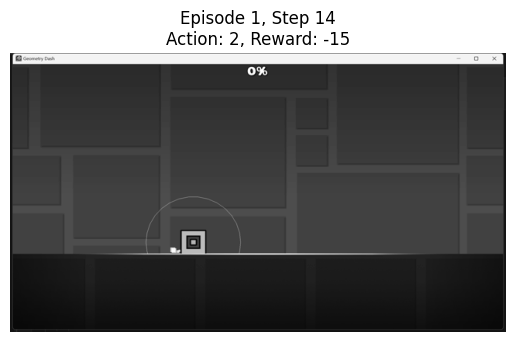

Step 14: Action=2, Reward=-15, Terminated=True
Episode ended due to termination.
Total Reward for Episode 1: -7.299999999999999


In [2]:
# Test environment with random actions
# Using matplotlib to visualize steps

env = GeometryDashEnv()
plt.ion()

num_episodes = 1
max_steps = 100

for episode in range(num_episodes):
    print(f"\n--- Episode {episode + 1} ---")
    obs, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        
        plt.imshow(obs.squeeze(), cmap='gray')
        plt.title(f'Episode {episode + 1}, Step {step + 1}\nAction: {action}, Reward: {reward}')
        plt.axis('off')
        plt.draw()
        plt.pause(0.01)
        
        print(f"Step {step + 1}: Action={action}, Reward={reward}, Terminated={terminated}")
        
        total_reward += reward
        
        if terminated or truncated:
            print("Episode ended due to termination.")
            break
    
    print(f"Total Reward for Episode {episode + 1}: {total_reward}")

env.close()
plt.ioff()
plt.show()

Training

In [ ]:
env = GeometryDashEnv()
env = DummyVecEnv([lambda: env])

# Load existing model
model = PPO.load("models/nopurrius3", env=env, device='cuda')

# Save temp model
model.save("models/temp_nopurrius")

# Create new model
model = PPO("CnnPolicy", env, n_steps=4096, batch_size=64, learning_rate=0.0003, device='cuda', verbose=1)

model = model.load("models/temp_nopurrius", env=env, device='cuda')

model.learn(total_timesteps=81920, reset_num_timesteps=False)
model.save("models/nopurrius3")
env.close()

Model Testing

In [ ]:
# Test an existing model

model = PPO.load("models/nopurrius3")
env = GeometryDashEnv()

obs, _ = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, _, _ = env.step(action)

    if terminated:
        obs, _ = env.reset()
        # To test one attempt
        # break

env.close()